In [34]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display  
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics

import warnings

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import timeit

from sklearn import svm

import plotly.graph_objects as pgo

In [35]:
# Load the 2 files
df = pd.read_csv('../data/ecg.csv')

In [36]:
df.head()

,-0.11252183,-2.8272038,-3.7738969,-4.3497511,-4.376041,-3.4749863,-2.1814082,-1.8182865,-1.2505219,-0.47749208,...,0.79216787,0.93354122,0.79695779,0.57862066,0.2577399,0.22807718,0.12343082,0.92528624,0.19313742,1.0
0,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
1,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
2,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
3,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0
4,-1.507674,-3.574550,-4.478011,-4.408275,-3.321242,-2.105171,-1.481048,-1.301362,-0.498240,-0.286928,...,1.089068,0.983369,1.014124,0.952629,0.749326,1.007076,1.634990,1.493365,-0.783134,1.0


In [37]:
df[df.columns[-1]].value_counts()

1.0
1.0    2918
0.0    2079
Name: count, dtype: int64

**Check balance of last columns**

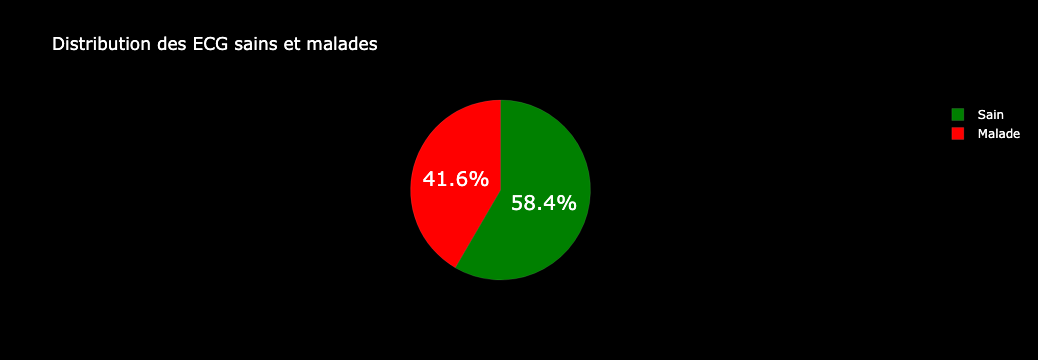

In [38]:
import plotly.graph_objects as pgo
values = y.value_counts()/y.shape[0]

fig = pgo.Figure(data=[pgo.Pie(labels=['Sain','Malade'], values=values)])
fig.update_traces(hoverinfo='label+percent', textinfo='percent', textfont_size=20,
                  marker=dict(colors=['green', 'red'], line=dict(color='white', width=0.1)))
fig.update_layout(
    title_text="Distribution des ECG sains et malades",
    title_font_color="white",
    legend_title_font_color="yellow",
    paper_bgcolor="black",
    plot_bgcolor='black',
    font_color="white",
)
fig.show()

In [39]:
X = df.drop(df.columns[-1], axis=1)  # Exclude the target column
y = df[df.columns[-1]]

print(X.shape)
print(y.shape)

(4997, 140)
(4997,)


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [41]:
std_scale = StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [45]:
def test_gamma(gammas, c, axs):
    
    for gamma in gammas:
        classifier = svm.SVC(C=c,kernel='rbf',gamma=gamma)
        classifier.fit(X_train_std, y_train)
        y_test_pred = classifier.decision_function(X_test_std)
        
        fpr, tpr, thre = metrics.roc_curve(y_test, y_test_pred)
        auc = metrics.auc(fpr, tpr)
                
        axs[0].plot(fpr,tpr,'-', lw=2,label='gamma=%f, AUC=%0.2f' % (gamma, auc))
        axs[0].set_xlabel("False positive rate", fontsize=16)
        axs[0].set_ylabel("True positive rate", fontsize=16)
        
        axs[0].set_title("SVM ROC Curve", fontsize=16)
        axs[0].legend(loc="lower right", fontsize=14)

    return plt

def gram_matrix(gamma, axs):  
    kmatrix = metrics.pairwise.rbf_kernel(X_train_std, gamma=gamma)  
    kmatrix100 = kmatrix[:100, :100]  
      
    im = axs[1].pcolor(kmatrix100, cmap=cm.PuRd)  
    plt.colorbar(im, ax=axs[1])  
      
    axs[1].set_xlim([0, kmatrix100.shape[0]])  
    axs[1].set_ylim([0, kmatrix100.shape[0]])  
      
    axs[1].invert_yaxis()  
    axs[1].xaxis.tick_top()  

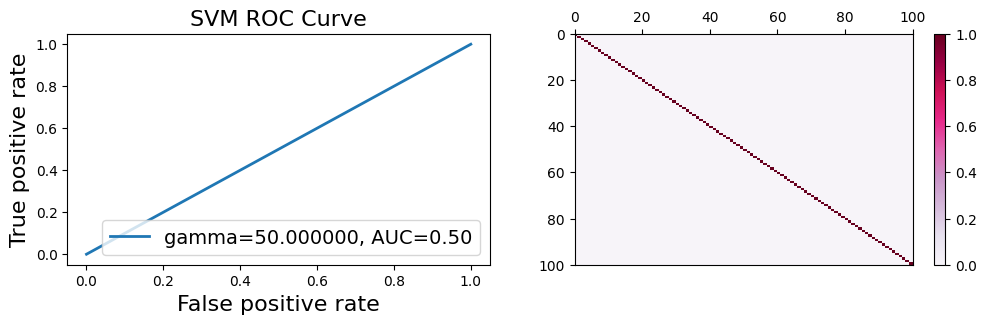

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  

test_gamma([50],1.0, axs)
gram_matrix(50, axs)

In [47]:
C_range = np.logspace(-3,3,7)
C_range

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [48]:
gamma_range = np.logspace(-2,1,4)
gamma_range

array([ 0.01,  0.1 ,  1.  , 10.  ])

In [49]:
param_grid = {'C': C_range, 'gamma': gamma_range} 
score = "roc_auc"

grid = GridSearchCV(svm.SVC(kernel="rbf"), param_grid,cv=5,scoring=score)

In [50]:
grid.fit(X_train_std, y_train)
print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_}")

The best parameters are {'C': 0.1, 'gamma': 0.01} with a score of 0.998475885955925


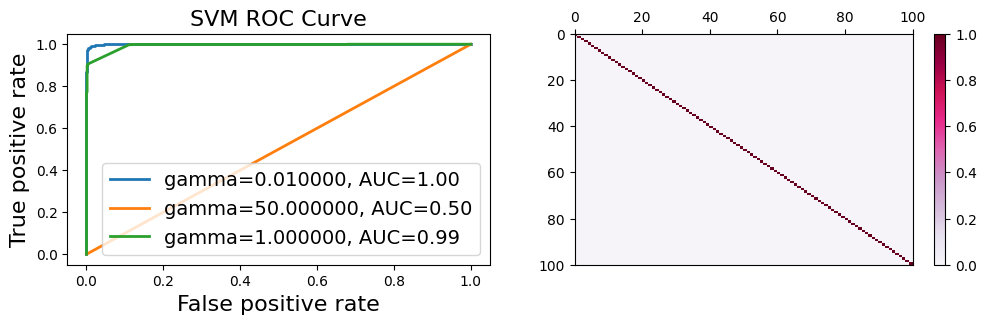

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  
test_gamma([0.01,50, 1],grid.best_params_["C"], axs)
gram_matrix(1, axs)